In [21]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score


from tqdm.auto import tqdm
tqdm.pandas()


import sys, os
sys.path.append(os.path.abspath('../'))
from scripts.utils import create_dir, get_runtime
import time
start_time = time.time()


In [49]:
# load 2029 data
data_2029 = pd.read_csv("../data/curated/suburb-rental-29.csv")

In [51]:
data_2029.drop(columns=["sa2_code"], inplace=True)

In [64]:
data_2029["year"] = 2029

In [65]:
# aggregate data by type and suburb for mean values
data_2029 = data_2029.groupby(["suburb", "type"]).mean().reset_index()
data_2029

,suburb,type,bed,bath,car,time_city,avg_property_price,rented_price,median_income,population,cpi,unemployment_rate,year
0,ABBOTSFORD,House,2.167554,1.322237,1.135431,679.714115,5.639555e+05,616.941300,96468.803763,15103.250000,2.5,4.59,2029.0
1,ABBOTSFORD,Unit/apmt,1.447879,1.262149,0.710838,1318.430406,5.851827e+05,459.171208,78486.538064,15151.714286,2.5,4.59,2029.0
2,AIRLY,Unit/apmt,3.500000,2.000000,4.000000,5196.600000,4.180000e+05,449.000000,58981.777086,16585.000000,2.5,4.59,2029.0
3,AIRPORT WEST,House,3.060563,1.416901,1.657746,1513.480282,7.809316e+05,469.974648,79824.130793,8658.000000,2.5,4.59,2029.0
4,AIRPORT WEST,Unit/apmt,2.820483,1.188097,1.307593,2099.976304,7.805535e+05,378.205519,66180.679225,7118.400000,2.5,4.59,2029.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2127,YENDON,Unit/apmt,4.000000,1.500000,3.000000,1286.500000,5.640000e+05,487.500000,71472.991280,6932.000000,2.5,4.59,2029.0
2128,YINNAR,House,3.664179,1.850746,2.955224,7215.509701,5.539780e+05,471.231343,61775.622836,12522.000000,2.5,4.59,2029.0
2129,YINNAR,Unit/apmt,2.805556,1.361111,2.277778,7308.608333,4.844415e+05,337.083333,64001.329257,12617.000000,2.5,4.59,2029.0
2130,YINNAR SOUTH,House,3.666667,2.000000,2.666667,7742.800000,9.439556e+05,440.000000,64001.329257,12617.000000,2.5,4.59,2029.0


In [22]:
# Load rental dataset from curated layer
rental_df = pd.read_csv('../data/curated/rental-17-24.csv')
rental_df['sa2_code'] = rental_df['sa2_code'].astype('Int64').astype(str)
rental_df = rental_df[[
    'suburb', 'sa2_code', 'type', 'year', 'bed', 'bath', 'car', 'median_income',
    'population', 'cpi', 'unemployment_rate', 'time_city', 'avg_property_price',
    'rented_price'
]]
rental_df

,suburb,sa2_code,type,year,bed,bath,car,median_income,population,cpi,unemployment_rate,time_city,avg_property_price,rented_price
0,MELBOURNE,206041505,Unit/apmt,2023,2.0,2.0,1.0,44492.400500,20027.0,5.60,3.691667,263.3,682488.770000,800
1,MELBOURNE,206041505,Unit/apmt,2023,2.0,2.0,1.0,44492.400500,20027.0,5.60,3.691667,263.3,682488.770000,800
2,MELBOURNE,206041505,Unit/apmt,2021,2.0,2.0,1.0,39300.000000,16098.0,3.50,4.200000,263.3,619543.745192,540
3,MELBOURNE,206041505,Unit/apmt,2023,2.0,1.0,0.0,44492.400500,20027.0,5.60,3.691667,263.3,682488.770000,720
4,MELBOURNE,206041505,Unit/apmt,2023,2.0,1.0,0.0,44492.400500,20027.0,5.60,3.691667,263.3,682488.770000,650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1409722,PAKENHAM,212011552,House,2024,3.0,1.0,0.0,55683.420715,28466.0,3.53,4.014286,3251.4,843219.858156,520
1409723,PAKENHAM,212011551,House,2024,3.0,2.0,2.0,57772.670788,7044.0,3.53,4.014286,3126.4,843219.858156,500
1409724,PAKENHAM,212011551,House,2024,3.0,2.0,2.0,57772.670788,7044.0,3.53,4.014286,3126.4,843219.858156,500
1409725,PAKENHAM,212011550,Unit/apmt,2024,4.0,2.0,2.0,58924.808098,9820.0,3.53,4.014286,3297.1,843219.858156,580


<Axes: xlabel='year', ylabel='rented_price'>

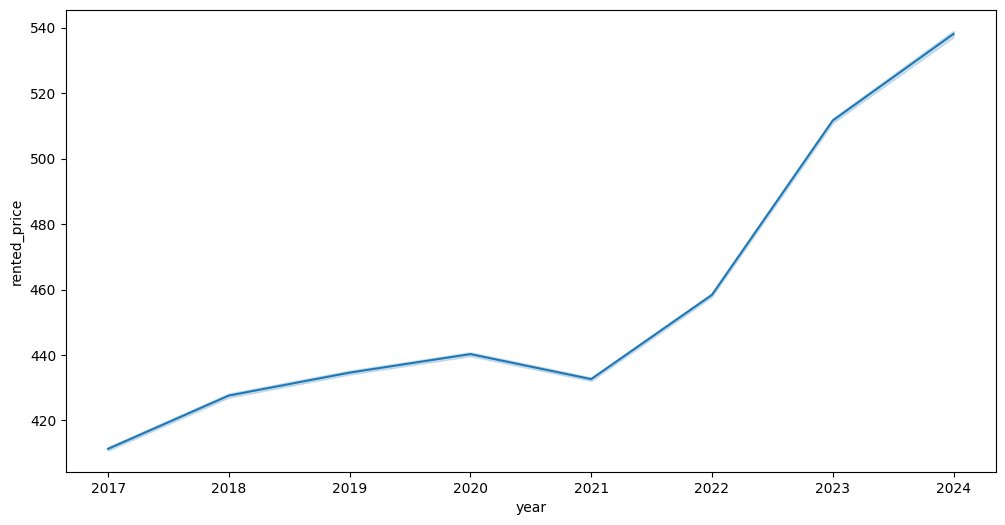

In [23]:
# plt the graph between rented price vs year
plt.figure(figsize=(12, 6))
sns.lineplot(data=rental_df, x='year', y='rented_price')

As the graphs shows a big difference between precovid and post covid, we will only be considering data from year 2021

In [24]:
rental_df.drop_duplicates(inplace=True)

In [25]:
rental_df = rental_df[rental_df["year"] >=2021]

year 2021 and 2022 will be used for training and year 2023 and 2024 will be used for testing

In [26]:
hist_df = rental_df[
    (rental_df['year'] >= 2021) &
    (rental_df['year'] <= 2023)
]
curr_df = rental_df[
    (rental_df['year'] > 2023) &
    (rental_df['year'] <= 2024)
]

In [27]:
# parition curr and hist dataframes based on type: 'House' and 'Unit/apmt'
hist_house_df = hist_df[hist_df['type'] == 'House']
hist_unit_df = hist_df[hist_df['type'] == 'Unit/apmt']
curr_house_df = curr_df[curr_df['type'] == 'House']
curr_unit_df = curr_df[curr_df['type'] == 'Unit/apmt']

# drop 'type' column
hist_house_df.drop(columns=['type'], inplace=True)
hist_unit_df.drop(columns=['type'], inplace=True)
curr_house_df.drop(columns=['type'], inplace=True)
curr_unit_df.drop(columns=['type'], inplace=True)

# print the shape of each dataframe
print('hist_house_df:', hist_house_df.shape)
print('hist_unit_df:', hist_unit_df.shape)
print('curr_house_df:', curr_house_df.shape)
print('curr_unit_df:', curr_unit_df.shape)

hist_house_df: (152132, 13)
hist_unit_df: (260605, 13)
curr_house_df: (26782, 13)
curr_unit_df: (51166, 13)


C:\Users\Richard\AppData\Local\Temp\ipykernel_31360\4217374014.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_house_df.drop(columns=['type'], inplace=True)
C:\Users\Richard\AppData\Local\Temp\ipykernel_31360\4217374014.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_unit_df.drop(columns=['type'], inplace=True)
C:\Users\Richard\AppData\Local\Temp\ipykernel_31360\4217374014.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a

In [28]:
# remove irregular data

hist_house_df = hist_house_df[hist_house_df["bath"] < 5]
curr_house_df = curr_house_df[curr_house_df["bath"] < 5]

In [29]:
MIN_INSTANCES_PER_SUBURB = 100

In [30]:
# find the number of suburbs with more than 1000 instances
hist_house_df['count'] = hist_house_df.groupby('suburb')['suburb'].transform('count')
hist_house_df[hist_house_df['count'] >= MIN_INSTANCES_PER_SUBURB]['suburb'].nunique()

hist_unit_df['count'] = hist_unit_df.groupby('suburb')['suburb'].transform('count')

curr_house_df['count'] = curr_house_df.groupby('suburb')['suburb'].transform('count')
curr_unit_df['count'] = curr_unit_df.groupby('suburb')['suburb'].transform('count')


C:\Users\Richard\AppData\Local\Temp\ipykernel_31360\2247219211.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hist_unit_df['count'] = hist_unit_df.groupby('suburb')['suburb'].transform('count')
C:\Users\Richard\AppData\Local\Temp\ipykernel_31360\2247219211.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  curr_unit_df['count'] = curr_unit_df.groupby('suburb')['suburb'].transform('count')


In [31]:


# add a new column which is the count of the entries within that suburb

high_confidence_unit_hist = hist_unit_df[hist_unit_df['count'] >= MIN_INSTANCES_PER_SUBURB]
high_confidence_house_hist = hist_house_df[hist_house_df['count'] >= MIN_INSTANCES_PER_SUBURB]

low_confidence_unit_hist = hist_unit_df[hist_unit_df['count'] < MIN_INSTANCES_PER_SUBURB]
low_confidence_house_hist = hist_house_df[hist_house_df['count'] < MIN_INSTANCES_PER_SUBURB]

high_unit_confidence_suburb = high_confidence_unit_hist['suburb'].unique()
low_unit_confidence_suburb = low_confidence_unit_hist['suburb'].unique()

high_house_confidence_suburb = high_confidence_house_hist['suburb'].unique()
low_house_confidence_suburb = low_confidence_house_hist['suburb'].unique()

In [32]:
high_confidence_house_curr = curr_house_df[curr_house_df['suburb'].isin(high_house_confidence_suburb)]
low_confidence_house_curr = curr_house_df[curr_house_df['suburb'].isin(low_house_confidence_suburb)]

high_confidence_house_curr = high_confidence_house_curr[high_confidence_house_curr['rented_price']>300]
low_confidence_house_curr = low_confidence_house_curr[low_confidence_house_curr['rented_price']>300]

high_confidence_unit_curr = curr_unit_df[curr_unit_df['suburb'].isin(high_unit_confidence_suburb)]
low_confidence_unit_curr = curr_unit_df[curr_unit_df['suburb'].isin(low_unit_confidence_suburb)]

high_confidence_unit_curr = high_confidence_unit_curr[high_confidence_unit_curr['rented_price']>200]
low_confidence_house_curr = low_confidence_house_curr[low_confidence_house_curr['rented_price']>200]

In [55]:
data_2029_house = data_2029[data_2029["type"] == "House"]
data_2029_unit = data_2029[data_2029["type"] == "Unit/apmt"]

In [69]:
numeric_features = ['bed, bath, car, year, median_income, population, cpi, unemployment_rate, time_city', 'avg_property_price',"count"]

from sklearn.neural_network import MLPRegressor
from sklearn.neighbors import KNeighborsRegressor

# Defining the ColumnTransformer for one-hot encoding 'type' and standardizing numeric columns
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features)
    ]
)

def run_0R(X_train, X_test, y_train):
    zero_r_model = DummyRegressor(strategy='mean')
    zero_r_model.fit(X_train, y_train)
    # print training score
    #print("ZeroR (Baseline) Model")
    #print(f"Training Score: {zero_r_model.score(X_train, y_train)}")
    return zero_r_model.predict(X_test)

def run_LR(X_train, X_test, y_train):
    # Initialize and fit the linear regression model
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # Get the predicted values
    predictions = lr_model.predict(X_test)
    
    # Extract the model coefficients
    coef = lr_model.coef_
    
    # Create a DataFrame to pair feature names with their corresponding coefficients
    feature_importance = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': coef
    })
    
    # Sort the DataFrame by the absolute value of the coefficients (most relevant feature first)
    feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
    feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)
    
    # Display the most relevant features (sorted by the coefficient's absolute value)
    
    
    return predictions,feature_importance

def run_RF(X_train, X_test, y_train):
    rf_model = RandomForestRegressor(n_estimators=100, random_state=1, max_depth=5, min_samples_split=5)
    rf_model.fit(X_train, y_train)

    return rf_model.predict(X_test)

def run_MLP(X_train, X_test, y_train):
    mlp_model = MLPRegressor(random_state=1, max_iter=300)
    mlp_model.fit(X_train, y_train)
    #print("ZeroR (Baseline) Model")
    #print(f"Training Score: {mlp_model.score(X_train, y_train)}")
    return mlp_model.predict(X_test)

def run_KNN(X_train, X_test, y_train):
    knn_model = KNeighborsRegressor(n_neighbors=5)
    knn_model.fit(X_train, y_train)
    #print("ZeroR (Baseline) Model")
    #print(f"Training Score: {knn_model.score(X_train, y_train)}")
    return knn_model.predict(X_test)

def run_SVR(X_train, X_test, y_train):
    from sklearn.svm import SVR
    svr_model = SVR(kernel='linear')
    svr_model.fit(X_train, y_train)
    #print("ZeroR (Baseline) Model")
    #print(f"Training Score: {svr_model.score(X_train, y_train)}")
    return svr_model.predict(X_test)

def run_combine_models(X_train, X_test, y_train, weight_lr=0.5, weight_rf=0.5):
    # Ensure weights sum to 1
    assert weight_lr + weight_rf == 1, "The sum of the weights should be 1."
    
    # --- Linear Regression ---
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    lr_predictions = lr_model.predict(X_test)
    
    # Extract the model coefficients for LR
    coef = lr_model.coef_
    feature_importance_lr = pd.DataFrame({
        'Feature': X_train.columns,
        'Coefficient': coef
    })
    feature_importance_lr['Abs_Coefficient'] = feature_importance_lr['Coefficient'].abs()
    feature_importance_lr = feature_importance_lr.sort_values(by='Abs_Coefficient', ascending=False)

    # --- Random Forest ---
    rf_model = RandomForestRegressor(n_estimators=100, random_state=1, max_depth=5, min_samples_split=5)
    rf_model.fit(X_train, y_train)
    rf_predictions = rf_model.predict(X_test)
    
    # Combine predictions by averaging (weighted average can be applied)
    combined_predictions = (weight_lr * lr_predictions) + (weight_rf * rf_predictions)

    # You can choose to return the feature importances for both models or just LR
    return combined_predictions, feature_importance_lr



def display_metrics(y_test, y_pred_zero_r,y_pred_lr,y_pred_rf):
    # Compute evaluation metrics for ZeroR
    mse_zero_r = mean_squared_error(y_test, y_pred_zero_r)
    r2_zero_r = r2_score(y_test, y_pred_zero_r)
    # Compute evaluation metrics for Linear Regression
    mse_lr = mean_squared_error(y_test, y_pred_lr)
    r2_lr = r2_score(y_test, y_pred_lr)
    # Compute evaluation metrics for Random Forest
    mse_rf = mean_squared_error(y_test, y_pred_rf)
    r2_rf = r2_score(y_test, y_pred_rf)
    # get variance of the target variable
    variance = y_test.var()      
    # Output the results
    print("ZeroR (Baseline) Model")
    print(f"Mean Squared Error (MSE): {mse_zero_r}")
    print(f"R-Squared (R2 Score): {r2_zero_r}\n")
    print("Linear Regression Model")
    print(f"Mean Squared Error (MSE): {mse_lr}")
    print(f"R-Squared (R2 Score): {r2_lr}\n")
    print("Random Forest Model")
    print(f"Mean Squared Error (MSE): {mse_rf}")
    print(f"R-Squared (R2 Score): {r2_rf}")
    print(f"Variance of the target variable: {variance}")

In [70]:
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score

def modeling(df1, df2):
    Prior_2021 = df1
    After_2021 = df2

    suburb_testing = After_2021['suburb'].unique()
    
    # Initialize lists to collect results
    average_mse_zero_r = []
    average_mse_lr = []
    average_mse_rf = []
    average_r2_combine = []
    
    bad_prediction = []
    good_prediction = []
    
    # Initialize dictionary to aggregate feature importances across all suburbs
    feature_importance_sum = pd.DataFrame()

    # Loop over all suburbs
    for i in suburb_testing:
        # Filter the data by suburb
        Prior_2021_suburb = Prior_2021[Prior_2021['suburb'] == i]
        After_2021_suburb = After_2021[After_2021['suburb'] == i]

        X_train = Prior_2021_suburb.drop(columns=['rented_price', 'suburb', 'sa2_code'])
        X_test = After_2021_suburb.drop(columns=['rented_price', 'suburb', 'sa2_code'])
        y_train = Prior_2021_suburb['rented_price']
        y_test = After_2021_suburb['rented_price']

        # Run the models
        y_pred_zero_r = run_0R(X_train, X_test, y_train)
        y_pred_lr, feature_importance = run_LR(X_train, X_test, y_train)
        y_pred_rf = run_RF(X_train, X_test, y_train)
        y_pred_combine, _ = run_combine_models(X_train, X_test, y_train, weight_lr=0.5, weight_rf=0.5)

        # Calculate R2 scores
        r2_lr = r2_score(y_test, y_pred_lr)
        r2_rf = r2_score(y_test, y_pred_rf)
        r2_combine = r2_score(y_test, y_pred_combine)

        # Store the R2 results for analysis
        average_mse_zero_r.append(r2_score(y_test, y_pred_zero_r))
        average_mse_lr.append(r2_lr)
        average_mse_rf.append(r2_rf)
        average_r2_combine.append(r2_combine)
        
        # Sum up feature importances across suburbs for LR
        if feature_importance_sum.empty:
            feature_importance_sum = feature_importance.set_index('Feature')
        else:
            feature_importance_sum['Coefficient'] += feature_importance.set_index('Feature')['Coefficient']

    # Remove negative R2 values
    average_mse_lr = [x for x in average_mse_lr if x >= 0]
    average_mse_rf = [x for x in average_mse_rf if x >= 0] 
    average_r2_combine = [x for x in average_r2_combine if x >= 0]
    
    # Print average R2 scores for LR, RF, and Combined
    print('Average R2 Score LR:', np.mean(average_mse_lr))
    print('Average R2 Score RF:', np.mean(average_mse_rf))
    print('Average R2 Score Combined:', np.mean(average_r2_combine))
    
    # Print bad and good predictions if applicable
    # print(bad_prediction)
    # print(good_prediction)

    # Find the top 5 most important features overall (based on summed coefficients from LR)
    feature_importance_sum['Abs_Coefficient'] = feature_importance_sum['Coefficient'].abs()
    top_5_features = feature_importance_sum.sort_values(by='Abs_Coefficient', ascending=False).head(5)

    # Print the top 5 most important features
    print("Top 5 most important features across all suburbs:")
    print(top_5_features[['Coefficient', 'Abs_Coefficient']])


# Modelling high confidnece house

In [35]:


# fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# # Flatten the axes array for easy iteration
# axes = axes.flatten()

# # Loop over the years and plot each year's distribution in a separate subplot
# for idx, i in enumerate(range(2017, 2025)):
#     wyndham_vale = rental_df[(rental_df['suburb'] == 'BALLARAT CENTRAL') & (rental_df['year'] == i)]
#     sns.histplot(wyndham_vale["rented_price"], kde=True, bins=30, ax=axes[idx])
#     axes[idx].set_title(f'MELBOURNE Rented Price Distribution in {i}')
#     axes[idx].set_xlabel('Rented Price')
#     axes[idx].set_ylabel('Frequency')

# # Adjust layout
# plt.tight_layout()

# # Show the plot
# plt.show()

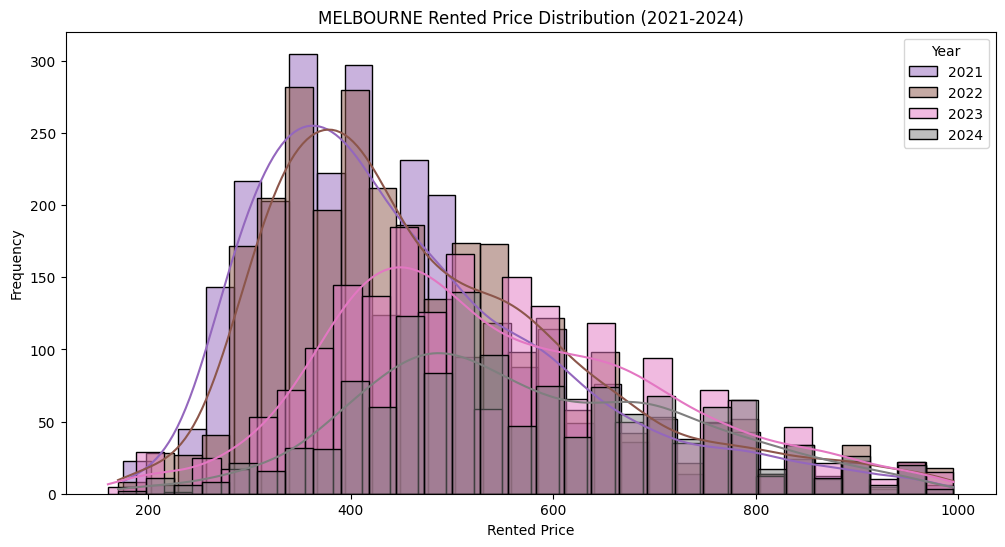

In [36]:
# Create a figure for the combined plot
plt.figure(figsize=(12, 6))

# Loop over the years and plot each year's distribution on the same figure
for i in range(2017, 2025):
    wyndham_vale = rental_df[(rental_df['suburb'] == 'SOUTH YARRA') & (rental_df['year'] == i)]
    sns.histplot(wyndham_vale["rented_price"], kde=True, label=f'{i}', bins=30)

# Add title and labels
plt.title('MELBOURNE Rented Price Distribution (2021-2024)')
plt.xlabel('Rented Price')
plt.ylabel('Frequency')

# Show the legend
plt.legend(title='Year')

# Display the plot
plt.show()

In [43]:
df1 = high_confidence_house_hist
df2 = high_confidence_house_curr

In [71]:
data_2029_house_predicted = modeling(df1,df2)

C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kf

Average R2 Score LR: 0.42563424180249276
Average R2 Score RF: 0.36232370720002083
Average R2 Score Combined: 0.3851209576142885
Top 5 most important features across all suburbs:
                     Coefficient  Abs_Coefficient
Feature                                          
median_income       6.034642e+11     6.034642e+11
avg_property_price -3.477328e+11     3.477328e+11
year                7.381126e+10     7.381126e+10
population          2.249867e+09     2.249867e+09
cpi                 1.293857e+08     1.293857e+08


C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kf

# Modelling high confidence unit/apmt

In [72]:
# bathroom should be less than 2

high_confidence_unit_hist = high_confidence_unit_hist[high_confidence_unit_hist['bath'] <= 2]
high_confidence_unit_curr = high_confidence_unit_curr[high_confidence_unit_curr['bath'] <= 2]

high_confidence_unit_hist = high_confidence_unit_hist[high_confidence_unit_hist['bath'] > 0]
high_confidence_unit_curr = high_confidence_unit_curr[high_confidence_unit_curr['bath'] > 0]

# car park should be less than 3

high_confidence_unit_hist = high_confidence_unit_hist[high_confidence_unit_hist['car'] <= 3]
high_confidence_unit_curr = high_confidence_unit_curr[high_confidence_unit_curr['car'] <= 3]

# eliminate apartment with more than 1400 per week

high_confidence_unit_hist = high_confidence_unit_hist[high_confidence_unit_hist['rented_price'] <= 1400]
high_confidence_unit_curr = high_confidence_unit_curr[high_confidence_unit_curr['rented_price'] <= 1400]

In [73]:
df1 = high_confidence_unit_hist
df2 = high_confidence_unit_curr

modeling(df1,df2)


Average R2 Score LR: 0.4053941467049732
Average R2 Score RF: 0.3814542266855049
Average R2 Score Combined: 0.4178955162022719
Top 5 most important features across all suburbs:
          Coefficient  Abs_Coefficient
Feature                               
bed      19820.173585     19820.173585
bath     17647.053234     17647.053234
car       4847.098394      4847.098394
cpi      -2825.264125      2825.264125
year       562.713489       562.713489


In [82]:
# taking Melbourne city as an example to observe the model performance

Melbourne_train = high_confidence_unit_hist[high_confidence_unit_hist['suburb'] == 'MELBOURNE']
Melbourne_test = high_confidence_unit_curr[high_confidence_unit_curr['suburb'] == 'MELBOURNE']

X_train = Melbourne_train.drop(columns=['rented_price','suburb','sa2_code'])
X_test = Melbourne_test.drop(columns=['rented_price','suburb','sa2_code'])
y_train = Melbourne_train['rented_price']
y_test = Melbourne_test['rented_price']


def run_RF(X_train, X_test, y_train):
    rf_model = RandomForestRegressor(n_estimators=150, random_state=1, max_depth=5)
    rf_model.fit(X_train, y_train)
    #print("ZeroR (Baseline) Model")
    # print important features
    importances = rf_model.feature_importances_
    feature_names = X_train.columns  # If X_train is a pandas DataFrame
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    })
    feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

    print(feature_importance_df.head())  # Display the top features

    return rf_model.predict(X_test)

def run_logistic(X_train, X_test, y_train):
    from sklearn.linear_model import LogisticRegression
    logistic_model = LogisticRegression(random_state=1)
    logistic_model.fit(X_train, y_train)
    #print("ZeroR (Baseline) Model")
    #print(f"Training Score: {logistic_model.score(X_train, y_train)}")
    return logistic_model.predict(X_test)

def run_ridge(X_train, X_test, y_train):
    from sklearn.linear_model import Ridge
    ridge_model = Ridge(alpha=1.0)
    ridge_model.fit(X_train, y_train)
    #print("ZeroR (Baseline) Model")
    #print(f"Training Score: {ridge_model.score(X_train, y_train)}")
    return ridge_model.predict(X_test)

y_pred_rf = run_RF(X_train, X_test, y_train)
y_pred_ridge = run_ridge(X_train, X_test, y_train)


r2_rf = r2_score(y_test, y_pred_rf)
r2_ridge = r2_score(y_test, y_pred_ridge)


print(r2_rf,r2_ridge)
Melbourne_test

         Feature  Importance
2           bath    0.548673
1            bed    0.252504
4  median_income    0.061772
8      time_city    0.043522
3            car    0.042891
-0.39508013499041406 0.32543279560227534


,suburb,sa2_code,year,bed,bath,car,median_income,population,cpi,unemployment_rate,time_city,avg_property_price,rented_price,count
0,MELBOURNE,206041505,2023,2.0,2.0,1.0,44492.400500,20027.0,5.60,3.691667,263.3,682488.770000,800,8309
3,MELBOURNE,206041505,2023,2.0,1.0,0.0,44492.400500,20027.0,5.60,3.691667,263.3,682488.770000,720,8309
4,MELBOURNE,206041505,2023,2.0,1.0,0.0,44492.400500,20027.0,5.60,3.691667,263.3,682488.770000,650,8309
6,MELBOURNE,206041504,2023,2.0,2.0,0.0,39250.645733,21566.0,5.60,3.691667,210.9,682488.770000,830,8309
12,MELBOURNE,206041505,2023,2.0,1.0,0.0,44492.400500,20027.0,5.60,3.691667,232.5,682488.770000,660,8309
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408454,MELBOURNE,206041505,2024,2.0,2.0,0.0,42430.858339,20162.0,3.53,4.014286,156.4,696152.566964,820,8309
1408455,MELBOURNE,206041503,2024,1.0,1.0,0.0,42412.280478,11840.0,3.53,4.014286,168.9,696152.566964,270,8309
1408457,MELBOURNE,206041504,2024,1.0,1.0,0.0,37039.553272,22750.0,3.53,4.014286,208.5,696152.566964,470,8309
1408458,MELBOURNE,206041503,2024,2.0,1.0,1.0,42412.280478,11840.0,3.53,4.014286,158.1,696152.566964,600,8309


# Modelling low confidence house

In [47]:
df1 = low_confidence_unit_hist
df2 = low_confidence_unit_curr
modeling(df1,df2)

C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kf

Average R2 Score LR: 0.4377950712265909
Average R2 Score RF: 0.4036315081014414
Average R2 Score Combined: 0.45248314748711144
Top 5 most important features across all suburbs:
                     Coefficient  Abs_Coefficient
Feature                                          
median_income       6.108438e+09     6.108438e+09
population          1.642715e+09     1.642715e+09
avg_property_price -3.219698e+08     3.219698e+08
year                2.010612e+07     2.010612e+07
cpi                -2.263514e+06     2.263514e+06


# Modelling low confidence unit/apmt

In [48]:
df1 = low_confidence_house_hist
df2 = low_confidence_house_curr
modeling(df1,df2)

C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kf

Average R2 Score LR: 0.42563424180249276
Average R2 Score RF: 0.36232370720002083
Average R2 Score Combined: 0.3851209576142885
Top 5 most important features across all suburbs:
                     Coefficient  Abs_Coefficient
Feature                                          
median_income       6.034642e+11     6.034642e+11
avg_property_price -3.477328e+11     3.477328e+11
year                7.381126e+10     7.381126e+10
population          2.249867e+09     2.249867e+09
cpi                 1.293857e+08     1.293857e+08


C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_regression.py:1187: UndefinedMetricWarning: R^2 score is not well-defined with less than two samples.
  warnings.warn(msg, UndefinedMetricWarning)
C:\Users\Richard\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kf

<Axes: >

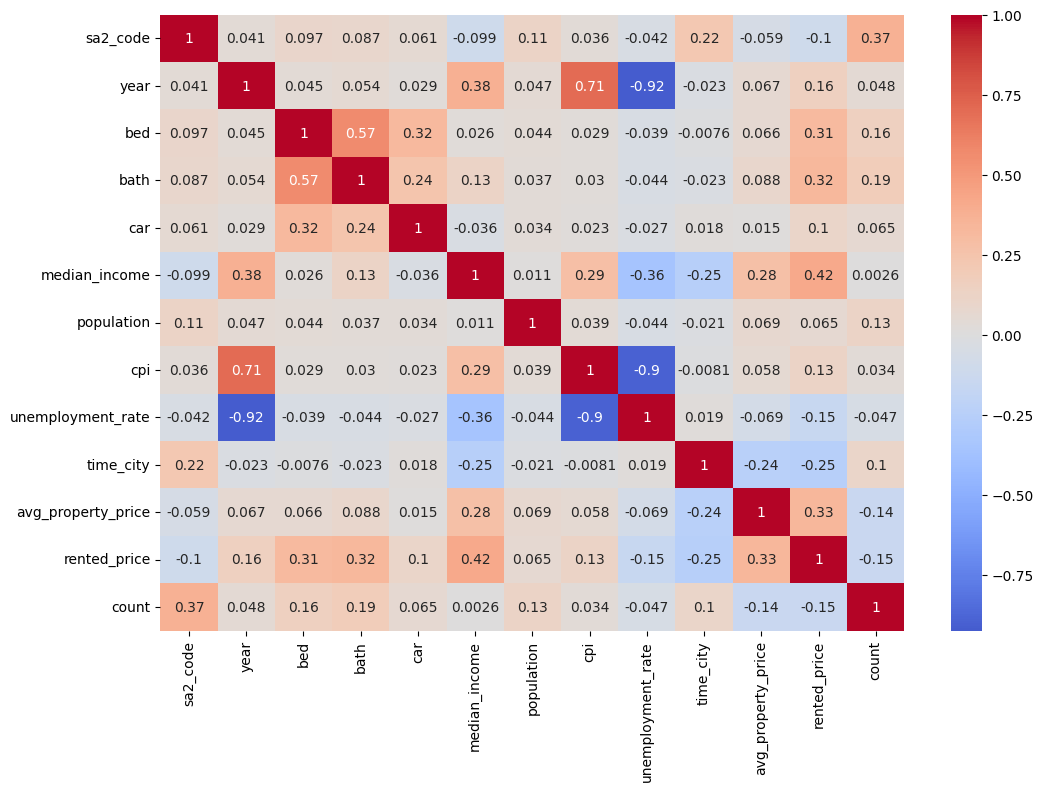

In [89]:
# plot a correlation map between all variables
plt.figure(figsize=(12, 8))
sns.heatmap(high_confidence_house_hist.drop(columns=["suburb"]).corr(), annot=True, cmap='coolwarm', center=0)